In [4]:
import pandas as pd
import numpy as np
import re
import itertools

from xgboost import XGBClassifier

In [5]:
# helper functions
gain_sub3 = pd.read_csv('data/gain_importance_submission3.csv')

# encodes non-numeric values as numeric
def encode_cats(data):
    non_numeric_cols = list(data.select_dtypes(exclude=np.number).columns)
    data[non_numeric_cols] = data[non_numeric_cols].astype('category').apply(lambda x: x.cat.codes)
    return data

# adds average of features, weighted by relative gain importance
def add_weighted_avg(data, feature_list_dict):
    for k,v in feature_list_dict.items():
        features = data[v]
        gain = gain_sub3[v]
        data[k] = features.fillna(0).dot( gain.transpose() ).div( gain.dot( gain.transpose() ))

# adds quadratic terms in top n features: e.g. x_1, x_2, x_3 are added as x_1 **2, x_1 * x_2, x_1 * x_3, ..., x_2 * x_3. 
# using n features adds 2 * (n choose 2)new features.
def add_products(data, feature_list):
    pairs = list(itertools.product(feature_list, feature_list))
    for pair in pairs:
        data[str(pair[0] + "*" + pair[1])] = data[pair[0]] * data[pair[1]]

In [6]:
train_identity = pd.read_csv('data/train_identity.csv')
train_transaction = pd.read_csv('data/train_transaction.csv')
train = train_transaction.merge(train_identity, on='TransactionID', how='outer')
train = encode_cats(train)

test_identity = pd.read_csv('data/test_identity.csv')
test_transaction = pd.read_csv('data/test_transaction.csv')
test = test_transaction.merge(test_identity, on='TransactionID', how='outer')
test.rename( columns = lambda x: x.replace('id-', 'id_'), inplace=True )
test = encode_cats(test)

#there is no difference between training on top 220 features vs training on all features.
top_candidates = list(gain_sub3.sort_values(ascending=False, by=0, axis=1, ).iloc[:,0:220].columns)

In [10]:
gain_sub3

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_30,id_31,id_32,id_33,id_34,id_36,id_37,id_38,DeviceType,DeviceInfo
0,5.928217,7.550112,7.383114,10.474966,6.013476,7.874835,13.633933,5.70699,6.103688,17.249729,...,5.48623,4.201232,5.80969,4.728217,3.24205,1.005004,3.907368,3.186882,5.624442,5.55299


<Axes: xlabel='isFraud', ylabel='TransactionDT'>

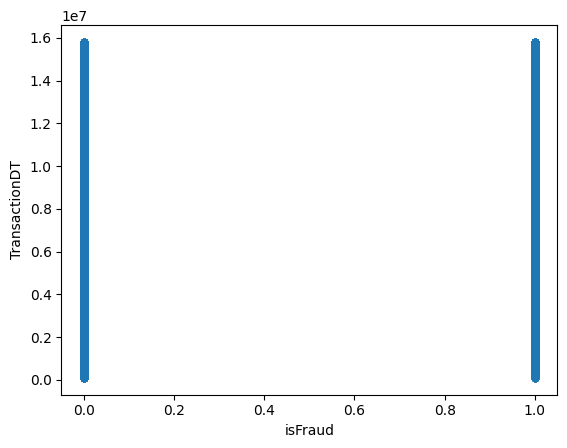

In [7]:
train.plot.scatter(x='isFraud', y='TransactionDT')

In [39]:
V_list  =   [x for x in top_candidates if re.match('V+[0-9]*', x)]
C_list  =   [x for x in top_candidates if re.match('C+[0-9]*', x)]
D_list  =   [x for x in top_candidates if re.match('D+[0-9]*', x)]
M_list  =   [x for x in top_candidates if re.match('M+[0-9]*', x)]
id_list =   [x for x in top_candidates if re.match('id+_+[0-9]*', x)]

others = list( set(top_candidates) - set(V_list + C_list + D_list + id_list + M_list) )

cat_dict = {
    'V_list':           V_list, 
    'C_list':           C_list, 
    'D_list':           D_list ,
    'id_list':          id_list,
    'M_list':           M_list, 
    'others':           others
}

cross_cat = [L[0] for L in cat_dict.values()]

cat_dict.update( {'cross_cat' : cross_cat})

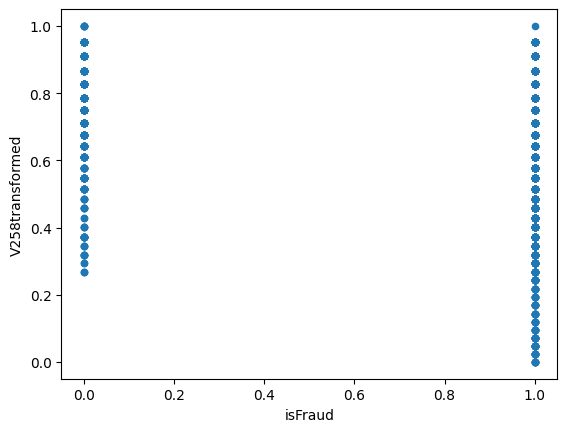

In [40]:
# Visualizing VXXX category

max_val = np.max(train['V258'])
import math

def transformation(x): 
    return math.tan( math.pi * abs((x/max_val)  - 0.5)/2 ) 

train['V258transformed'] = train['V258'].apply(transformation)
train.plot.scatter(x='isFraud', y='V258transformed')

experimental_list = ['V258transformed']

In [41]:
X = train[top_candidates + experimental_list]
y = train['isFraud']

In [42]:
add_weighted_avg(X, cat_dict)

quad_cat = list(pd.read_csv('data/gain_importance_for_quadratics_submission14.csv')['0'].values)
add_products(X, quad_cat)

C:\Users\19368\AppData\Local\Temp\ipykernel_29248\1484864349.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[k] = features.fillna(0).dot( gain.transpose() ).div( gain.dot( gain.transpose() ))
C:\Users\19368\AppData\Local\Temp\ipykernel_29248\1484864349.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[k] = features.fillna(0).dot( gain.transpose() ).div( gain.dot( gain.transpose() ))
C:\Users\19368\AppData\Local\Temp\ipykernel_29248\1484864349.py:15: SettingWithCopyWarning: 
A value is tryi

In [43]:
xgb = XGBClassifier(device='cuda',
                    n_estimators=4000,
                    learning_rate=0.001,
                    max_depth=16,
                    objective='binary:logistic'
                    )

In [44]:
xgb.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=16, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=4000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [49]:
test['V258transformed'] = test['V258'].apply(transformation)
test = test[top_candidates + experimental_list]

add_weighted_avg(test, cat_dict)
add_products(test, quad_cat)

C:\Users\19368\AppData\Local\Temp\ipykernel_29248\801991148.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['V258transformed'] = test['V258'].apply(transformation)
C:\Users\19368\AppData\Local\Temp\ipykernel_29248\1484864349.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[k] = features.fillna(0).dot( gain.transpose() ).div( gain.dot( gain.transpose() ))
C:\Users\19368\AppData\Local\Temp\ipykernel_29248\1484864349.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [50]:
preds = xgb.predict_proba(test)[:,1]
submission = pd.read_csv('data/sample_submission.csv')
submission['isFraud'] = preds
submission 

c:\Users\19368\anaconda3\envs\Kaggle\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:28:23] WARNING: D:\bld\xgboost-split_1738880170463\work\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


,TransactionID,isFraud
0,3663549,0.006134
1,3663550,0.007974
2,3663551,0.011695
3,3663552,0.003856
4,3663553,0.004841
...,...,...
506686,4170235,0.015302
506687,4170236,0.012015
506688,4170237,0.010028
506689,4170238,0.011078


In [51]:
import os
i=0
while os.path.exists('submissions/submission%s.csv' % i):
    i+=1

submission.to_csv('submissions/submission%s.csv' % i, index=False)